# Transformer Network Application: Question Answering

**Objectives**:

* Perform extractive Question Answering 
* Fine-tune a pre-trained transformer model to a custom dataset
* Implement a QA model in TensorFlow

<a name='1'></a>
## 1 - Extractive Question Answering

Question answering (QA) is a task of natural language processing that aims to automatically answer questions. The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question. For example, when tasked with answering the question 'When will Jane go to Africa?' given the text data 'Jane visits Africa in September', the question answering model will highlight 'September'.

* You will use a variation of the Transformer model you built in the last assignment to answer questions about stories.
* You will implement extractive QA model in TensorFlow and in PyTorch.

<a name='1-1'></a>
### 1.1 - Data preprocessing

Run the following cell to load the [QA bAbI dataset](https://research.fb.com/downloads/babi/), which is one of the bAbI datasets generated by Facebook AI Research to advance natural language processing.

In [ ]:
!pip install datasets
!pip install transformers

In [21]:
from datasets import load_from_disk

# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('data/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


Take a look at the format of the data. For a given story, there are two sentences which serve as the context, and one question. Each of these phrases has an ID. There is also a supporting fact ID which refers to a sentence in the story that helps answer the question. For example, for the question 'What is east of the hallway?', the supporting fact 'The bedroom is east of the hallway' has the ID '2'. There is also the answer, 'bedroom' for the question.

In [22]:
#checking if all data has same format
type_set=set()
for story in babi_dataset['train']:
    if str(story['story']['type']) not in type_set:
        type_set.add(str(story['story']['type']))

print(type_set)

{'[0, 0, 1]'}


To make the data easier to work with, we can flatten the dataset to transform it from a dictionary structure to a table structure.

In [23]:
flattened_babi = babi_dataset.flatten()

In [24]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [25]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

In [26]:
def get_question_and_facts(story):
    '''
    Returns dictionary with question,sentences and answer.
    
    Arguments:
    story -- dictionary of one training example
    
    Returns:
    dic -- processed dictionary
    
    '''
    
    dic={}
    dic['question']=story['story.text'][2]
    dic['sentences']=' '.join( story['story.text'][:2] )
    dic['answer']=story['story.answer'][2]
    
    return dic

In [27]:
processed=flattened_babi.map(get_question_and_facts)

In [28]:
processed['test'][55]

{'story.answer': ['', '', 'garden'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The garden is east of the hallway.',
  'The bedroom is west of the hallway.',
  'What is east of the hallway?'],
 'story.type': [0, 0, 1],
 'question': 'What is east of the hallway?',
 'sentences': 'The garden is east of the hallway. The bedroom is west of the hallway.',
 'answer': 'garden'}

The goal of extractive QA is to find the part of the text that contains the answer to the question. You will identify the position of the answer using the indexes of the string. For example, if the answer to some question was 'September', you would need to find the start and end string indices of the word 'September' in the context sentence 'Jane visits Africa in September.'


Use this next function to get the start and end indices of the answer in each of the stories in your dataset.

In [29]:
def get_start_end_idx(story):
    '''
    Returns start and end index of answer in sentence in story dictionary.
    
    Arguments:
    story --  dictionary of one training example
    
    Returns:
    dictionary with start and end indices
    '''
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [30]:
processed = processed.map(get_start_end_idx)

In [31]:
processed['train'][158]

{'story.answer': ['', '', 'hallway'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The office is west of the hallway.',
  'The hallway is west of the garden.',
  'What is the garden east of?'],
 'story.type': [0, 0, 1],
 'question': 'What is the garden east of?',
 'sentences': 'The office is west of the hallway. The hallway is west of the garden.',
 'answer': 'hallway',
 'str_idx': 26,
 'end_idx': 33}

In [32]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


<a name='1-2'></a>
### 1.2 - Tokenize and Align with 🤗 Library

Now you have all the data you need to train a Transformer model to perform Question Answering!. To feed text data to a Transformer model, you will need to tokenize your input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer you use must match the Transformer model type you are using! In this exercise, you will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of your sequence to 512 and pads with zeros. 

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word with a `tokenize_and_align()` function. In this case, since you are interested in the start and end indices of the answer, you will want to align the index of the sentence to match the index of the token for a word. 


In [33]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [34]:
tokenizer

DistilBertTokenizerFast(name_or_path='tokenizer/', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length

    #Returning padded sequence of max length 512
    return {'input_ids': pad_sequences([encoding['input_ids']], maxlen=tokenizer.model_max_length, dtype='int32', padding='post', truncating='post')[0],
          'attention_mask': pad_sequences([encoding['attention_mask']], maxlen=tokenizer.model_max_length, dtype='int32', padding='post', truncating='post')[0],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [37]:
qa_dataset = processed.map(tokenize_align)

  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

In [38]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [39]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

<a name='2'></a>
# 2 - Training 

Now that you have finished tokenizing and aligning your data, you can feed it into a pre-trained 🤗 Transformer model! You will use a DistilBERT model, which matches the tokenizer you used to preprocess your data.

In [40]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [41]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-cased-distilled-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [42]:
import tensorflow as tf

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
#train_features = {x: train_ds[x].to_tensor(default_value=0, shape=[None, tokenizer.model_max_length]) for x in ['input_ids', 'attention_mask']}

train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}


train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

#### Training 

It is finally time to start training your model! 

* Create a custom training function using [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
* Target two loss functions, one for the start index and one for the end index. 
* `tf.GradientTape()` records the operations performed during forward prop for automatic differentiation during backprop. 


In [43]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))


Starting epoch: 0
Training loss (for one batch) at step 0: 7.9601
Training loss (for one batch) at step 20: 1.0594
Training loss (for one batch) at step 40: 0.8414
Training loss (for one batch) at step 60: 0.8245
Training loss (for one batch) at step 80: 0.7563
Training loss (for one batch) at step 100: 0.3336
Training loss (for one batch) at step 120: 0.6582
Starting epoch: 1
Training loss (for one batch) at step 0: 0.5923
Training loss (for one batch) at step 20: 0.0929
Training loss (for one batch) at step 40: 0.5528
Training loss (for one batch) at step 60: 0.5076
Training loss (for one batch) at step 80: 0.1348
Training loss (for one batch) at step 100: 0.0207
Training loss (for one batch) at step 120: 0.0242
Starting epoch: 2
Training loss (for one batch) at step 0: 0.1901
Training loss (for one batch) at step 20: 0.0011
Training loss (for one batch) at step 40: 0.0039
Training loss (for one batch) at step 60: 0.0004
Training loss (for one batch) at step 80: 0.0002


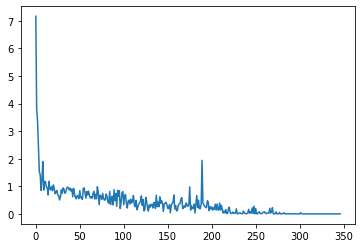

In [96]:
#Looking at losses
from matplotlib.pyplot import plot

plot(losses)

In [94]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

What is south of the bedroom? Garden
